<a id="lib"></a>
# Importing Required Libraries

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import FunctionTransformer
from catboost import CatBoostRegressor

from catboost import Pool, cv, CatBoostRegressor
from bayes_opt import BayesianOptimization
from bayes_opt import BayesianOptimization as BO
import warnings
from sklearn.model_selection import * 
from sklearn.metrics import *

<a id="read_data"></a>
# Reading Dataset

In [2]:
train_raw = pd.read_csv('dataset/train_data.csv', parse_dates=["startdate"])
test_raw = pd.read_csv('dataset/test_data.csv', parse_dates=["startdate"])
submit = pd.read_csv('dataset/sample_solution.csv')
target = 'contest-tmp2m-14d__tmp2m'
train_raw

,index,lat,lon,startdate,contest-pevpr-sfc-gauss-14d__pevpr,nmme0-tmp2m-34w__cancm30,nmme0-tmp2m-34w__cancm40,nmme0-tmp2m-34w__ccsm30,nmme0-tmp2m-34w__ccsm40,nmme0-tmp2m-34w__cfsv20,nmme0-tmp2m-34w__gfdlflora0,nmme0-tmp2m-34w__gfdlflorb0,nmme0-tmp2m-34w__gfdl0,nmme0-tmp2m-34w__nasa0,nmme0-tmp2m-34w__nmme0mean,contest-wind-h10-14d__wind-hgt-10,nmme-tmp2m-56w__cancm3,nmme-tmp2m-56w__cancm4,nmme-tmp2m-56w__ccsm3,nmme-tmp2m-56w__ccsm4,nmme-tmp2m-56w__cfsv2,nmme-tmp2m-56w__gfdl,nmme-tmp2m-56w__gfdlflora,nmme-tmp2m-56w__gfdlflorb,nmme-tmp2m-56w__nasa,nmme-tmp2m-56w__nmmemean,contest-rhum-sig995-14d__rhum,nmme-prate-34w__cancm3,nmme-prate-34w__cancm4,nmme-prate-34w__ccsm3,nmme-prate-34w__ccsm4,nmme-prate-34w__cfsv2,nmme-prate-34w__gfdl,nmme-prate-34w__gfdlflora,nmme-prate-34w__gfdlflorb,nmme-prate-34w__nasa,nmme-prate-34w__nmmemean,contest-wind-h100-14d__wind-hgt-100,nmme0-prate-56w__cancm30,nmme0-prate-56w__cancm40,nmme0-prate-56w__ccsm30,nmme0-prate-56w__ccsm40,nmme0-prate-56w__cfsv20,nmme0-prate-56w__gfdlflora0,nmme0-prate-56w__gfdlflorb0,nmme0-prate-56w__gfdl0,nmme0-prate-56w__nasa0,nmme0-prate-56w__nmme0mean,nmme0-prate-34w__cancm30,nmme0-prate-34w__cancm40,nmme0-prate-34w__ccsm30,nmme0-prate-34w__ccsm40,nmme0-prate-34w__cfsv20,nmme0-prate-34w__gfdlflora0,nmme0-prate-34w__gfdlflorb0,nmme0-prate-34w__gfdl0,nmme0-prate-34w__nasa0,nmme0-prate-34w__nmme0mean,contest-tmp2m-14d__tmp2m,contest-slp-14d__slp,contest-wind-vwnd-925-14d__wind-vwnd-925,nmme-prate-56w__cancm3,nmme-prate-56w__cancm4,nmme-prate-56w__ccsm3,nmme-prate-56w__ccsm4,nmme-prate-56w__cfsv2,nmme-prate-56w__gfdl,nmme-prate-56w__gfdlflora,nmme-prate-56w__gfdlflorb,nmme-prate-56w__nasa,nmme-prate-56w__nmmemean,contest-pres-sfc-gauss-14d__pres,contest-wind-uwnd-250-14d__wind-uwnd-250,nmme-tmp2m-34w__cancm3,nmme-tmp2m-34w__cancm4,nmme-tmp2m-34w__ccsm3,nmme-tmp2m-34w__ccsm4,nmme-tmp2m-34w__cfsv2,nmme-tmp2m-34w__gfdl,nmme-tmp2m-34w__gfdlflora,nmme-tmp2m-34w__gfdlflorb,nmme-tmp2m-34w__nasa,nmme-tmp2m-34w__nmmemean,contest-prwtr-eatm-14d__prwtr,contest-wind-vwnd-250-14d__wind-vwnd-250,contest-precip-14d__precip,contest-wind-h850-14d__wind-hgt-850,contest-wind-uwnd-925-14d__wind-uwnd-925,contest-wind-h500-14d__wind-hgt-500,cancm30,cancm40,ccsm30,ccsm40,cfsv20,gfdlflora0,gfdlflorb0,gfdl0,nasa0,nmme0mean,climateregions__climateregion,elevation__elevation,wind-vwnd-250-2010-1,wind-vwnd-250-2010-2,wind-vwnd-250-2010-3,wind-vwnd-250-2010-4,wind-vwnd-250-2010-5,wind-vwnd-250-2010-6,wind-vwnd-250-2010-7,wind-vwnd-250-2010-8,wind-vwnd-250-2010-9,wind-vwnd-250-2010-10,wind-vwnd-250-2010-11,wind-vwnd-250-2010-12,wind-vwnd-250-2010-13,wind-vwnd-250-2010-14,wind-vwnd-250-2010-15,wind-vwnd-250-2010-16,wind-vwnd-250-2010-17,wind-vwnd-250-2010-18,wind-vwnd-250-2010-19,wind-vwnd-250-2010-20,wind-uwnd-250-2010-1,wind-uwnd-250-2010-2,wind-uwnd-250-2010-3,wind-uwnd-250-2010-4,wind-uwnd-250-2010-5,wind-uwnd-250-2010-6,wind-uwnd-250-2010-7,wind-uwnd-250-2010-8,wind-uwnd-250-2010-9,wind-uwnd-250-2010-10,wind-uwnd-250-2010-11,wind-uwnd-250-2010-12,wind-uwnd-250-2010-13,wind-uwnd-250-2010-14,wind-uwnd-250-2010-15,wind-uwnd-250-2010-16,wind-uwnd-250-2010-17,wind-uwnd-250-2010-18,wind-uwnd-250-2010-19,wind-uwnd-250-2010-20,mjo1d__phase,mjo1d__amplitude,mei__mei,mei__meirank,mei__nip,wind-hgt-850-2010-1,wind-hgt-850-2010-2,wind-hgt-850-2010-3,wind-hgt-850-2010-4,wind-hgt-850-2010-5,wind-hgt-850-2010-6,wind-hgt-850-2010-7,wind-hgt-850-2010-8,wind-hgt-850-2010-9,wind-hgt-850-2010-10,sst-2010-1,sst-2010-2,sst-2010-3,sst-2010-4,sst-2010-5,sst-2010-6,sst-2010-7,sst-2010-8,sst-2010-9,sst-2010-10,wind-hgt-500-2010-1,wind-hgt-500-2010-2,wind-hgt-500-2010-3,wind-hgt-500-2010-4,wind-hgt-500-2010-5,wind-hgt-500-2010-6,wind-hgt-500-2010-7,wind-hgt-500-2010-8,wind-hgt-500-2010-9,wind-hgt-500-2010-10,icec-2010-1,icec-2010-2,icec-2010-3,icec-2010-4,icec-2010-5,icec-2010-6,icec-2010-7,icec-2010-8,icec-2010-9,icec-2010-10,wind-uwnd-925-2010-1,wind-uwnd-925-2010-2,wind-uwnd-925-2010-3,wind-uwnd-925-2010-4,wind-uwnd-925-2010

<a id = "process"></a>
# Preprocessing Dataset

In [36]:
def rmse(actual, predicted):
    return mean_squared_error(actual, predicted, squared=False)

def location_nom(train, test):

    scale = 14

    train.loc[:,'lat']=round(train.lat,scale)
    train.loc[:,'lon']=round(train.lon,scale)
    test.loc[:,'lat']=round(test.lat,scale)
    test.loc[:,'lon']=round(test.lon,scale)

    all_df = pd.concat([train, test], axis=0)
    all_df['loc_group'] = all_df.groupby(['lat','lon']).ngroup()
    train = all_df.iloc[:len(train)]
    test = all_df.iloc[len(train):].drop(target, axis=1)
    
    return train, test

def categorical_encode(train, test):
    le = LabelEncoder()
    train['climateregions__climateregion'] = le.fit_transform(train['climateregions__climateregion'])
    test['climateregions__climateregion'] = le.transform(test['climateregions__climateregion'])
    return train, test
    
def fill_na(df):
    df = df.sort_values(by=['loc_group', 'startdate']).ffill() #try some other filling methods
    return df

def sin_transformer(period):
    return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))

def cos_transformer(period):
    return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))

def add_season(df):
    month_to_season = {
      1: 0,
      2: 0,
      3: 1,
      4: 1,
      5: 1,
      6: 2,
      7: 2,
      8: 2, 
      9: 3, 
      10: 3,
      11: 3,
      12: 0
  }
    df['month'] = df['startdate'].dt.month
    df['season'] = df['month'].apply(lambda x: month_to_season[x])
    
    return df

def creat_new_featute(df):
    df['year'] = df['startdate'].dt.year
    #df['month'] = df['startdate'].dt.month
    #df['quarter'] = df.startdate.dt.quarter
    df['day_of_year'] = df['startdate'].dt.dayofyear
    #df['day_of_week'] = df['startdate'].dt.dayofweek
    #df['week_of_year'] = df['startdate'].dt.isocalendar().week
    df['day_of_year_sin'] = sin_transformer(365).fit_transform(df['day_of_year'])
    df['day_of_year_cos'] = cos_transformer(365).fit_transform(df['day_of_year'])
    del df['day_of_year']

    # encode the week with a period of 52
    #df['week_sin'] = sin_transformer(52).fit_transform(df['week_of_year'])
    #df['week_cos'] = cos_transformer(52).fit_transform(df['week_of_year'])
    #del df['week_of_year']

    # encode the month with a period of 12
    df['month_sin'] = sin_transformer(12).fit_transform(df['month'])
    df['month_cos'] = cos_transformer(12).fit_transform(df['month'])
    del df['month']

    # encode the season with a period of 4
    #df['season_sin'] = sin_transformer(4).fit_transform(df['season'])
    #df['season_cos'] = cos_transformer(4).fit_transform(df['season'])
    #del df['season']
    
    # encode the quarter with a period of 4
    #df['quarter_sin'] = sin_transformer(4).fit_transform(df['quarter'])
    #df['quarter_cos'] = cos_transformer(4).fit_transform(df['quarter'])
    #del df['quarter']
    
    return df

def target_min_max(train, test):
    # Concatenate train and test data
    all_df = pd.concat([train, test], axis=0)

    # Create new feature
    all_df['target_loc_group_max'] = all_df.groupby(['loc_group'])[target].transform('max')
    all_df['target_loc_group_min'] = all_df.groupby(['loc_group'])[target].transform('min')
    all_df['target_loc_group_std'] = all_df.groupby(['loc_group'])[target].transform('std')
    all_df['target_loc_group_mean'] = all_df.groupby(['loc_group'])[target].transform('mean')

    all_df['target_cr_max'] = all_df.groupby(['climateregions__climateregion'])[target].transform('max')
    all_df['target_cr_min'] = all_df.groupby(['climateregions__climateregion'])[target].transform('min')
    all_df['target_cr_std'] = all_df.groupby(['climateregions__climateregion'])[target].transform('std')
    all_df['target_cr_mean'] = all_df.groupby(['climateregions__climateregion'])[target].transform('mean')

    # Split back up
    train = all_df.iloc[:len(train)]
    test = all_df.iloc[len(train):]
    
    return train, test

def feature_engineering(train_raw, test_raw):
    
    train, test = location_nom(train_raw, test_raw)
    train = fill_na(train)
    train = add_season(train)
    test = add_season(test)
    train = creat_new_featute(train)
    test = creat_new_featute(test)
    train, test = categorical_encode(train, test)
    train, test = target_min_max(train, test)

    drop_cols = ['index', 'startdate', 'lat', 'lon', target]
    features = [col for col in train.columns if col not in drop_cols]
    X = train[features]
    X_test = test[features]
    y = train[target]

    return X, y, X_test

# Train and Validation

In [37]:
X, y, X_test = feature_engineering(train_raw.copy(), test_raw.copy())
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=42)
print(f'Train_shape: {X_train.shape}    |   Val_shape: {X_val.shape}    |   Test_shape: {X_test.shape}')

Train_shape: (251741, 256)    |   Val_shape: (123993, 256)    |   Test_shape: (31354, 256)


<a id = "adv"></a>
# Adversarial Validation
Adversarial Validation is a technique used to ensure that the distribution of data in the training set is similar to that of the test set. This is important because if the data in the training set is not representative of the test set, the model's predictions may not be accurate.

To perform Adversarial Validation, the following steps are taken:

1. Combine the train and test features into a single set
1. Create a target label to indicate whether a sample is from the train or test set
1. Build a model to classify samples as belonging to the train or test set

If the model is able to accurately distinguish between train and test samples, this indicates that there are features in the data that are different between the two sets. Adversarial Validation can be used to identify these features by using the feature importance generated by the model and evaluating the separation between the train and test datasets using the AUC metric.

Reference: Pan, J., Pham, V., Dorairaj, M., Chen, H., & Lee, J. Y. (2020). Adversarial validation approach to concept drift problem in user targeting automation systems at uber. [arXiv preprint arXiv:2004.03045](https://arxiv.org/abs/2004.03045).

In [5]:
import lightgbm as lgb

def run_adversial_validation(train_X_ml, test_X_ml):
    
    lgb_params = {'n_estimators':100,
                'boosting_type': 'gbdt',
                'objective': 'binary',
                'metric': 'auc',
                'verbose': 0
                    }
    # combine train & test features, create label to identify test vs train
    ad_y = np.array([1]*train_X_ml.shape[0] + [0]*test_X_ml.shape[0])
    ad_X = pd.concat([train_X_ml, test_X_ml])

    # evaluate model performance using cross-validation
    lgb_data = lgb.Dataset(ad_X, ad_y)
    cv_lgb = lgb.cv(lgb_params, lgb_data)

    print("Adversarial Validation AUC Score: {}".format(cv_lgb['auc-mean'][-1]))
    
    # train model & get feature importance
    ad_val_mod = lgb.train(lgb_params, lgb_data)
    
    print(pd.DataFrame(
        {'feat':ad_X.columns, 
         'imp':ad_val_mod.feature_importance()}).sort_values('imp', ascending = False))
    
    return ad_val_mod

In [6]:
ad_val_mod = run_adversial_validation(X_train, X_test)

/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:573: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


ValueError: DataFrame.dtypes for data must be int, float or bool.
Did not expect the data types in the following fields: week_of_year, week_sin, week_cos

It seems that there is a concept drift between train and test dataset and removing features like "contest-pevpr-sfc-gauss-14d__pevpr" and "nmme0-tmp2m-34w__cancm30" might help to increase the performance. 

In [ ]:
#X.drop('contest-pevpr-sfc-gauss-14d__pevpr', axis=1, inplace = True)
#X_test.drop('contest-pevpr-sfc-gauss-14d__pevpr', axis=1, inplace = True)

<a id="bocat"></a>
# Bayesian Optimization for CatBoost

[Here's](https://en.wikipedia.org/wiki/Bayesian_optimization) a wikipedia article about Bayesian Optimization, it's essentially a way to find good parameters by searching for these parameters sequentially. So the next parameter search values depend on the performance of the previous parameter values. This is a popular technique for finding optimal parameters. This may take some time to run. Also, you can tune many parameters, below are just some of the parameters that I choose to tune. For this notebook, I'm going to fix the number of estimators to be 100 to save time when running this notebook, but you can increase it to your liking or tune that parameter too if you'd like. You can change the number of iterations and initial points.

In [38]:
# source: https://medium.com/ai-in-plain-english/catboost-cross-validated-bayesian-hyperparameter-tuning-91f1804b71dd

X1, Y1 = X.copy(), y.copy()

In [39]:
Use_BO = False

if Use_BO:
    #n_estimators,
    # num_leaves
    def CB_opt(depth, learning_rate, subsample, l2_leaf_reg, model_size_reg): 

        scores = []
        skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 1944)
        trainx, valx, trainy, valy = train_test_split(X1, Y1, test_size=0.33, random_state=42)

        reg = CatBoostRegressor(   
                                        verbose = 0,
                                        iterations=10,
                                        n_estimators = 10,
                                        learning_rate = learning_rate,
                                        subsample = subsample, 
                                        l2_leaf_reg = l2_leaf_reg,
                                        max_depth = int(depth),
                                        #num_leaves = int(num_leaves),
                                        random_state = 1212,
                                        #grow_policy = "Lossguide",
                                        max_bin = int(max_bin),  
                                        use_best_model = True, 
                                        bootstrap_type='Bayesian',
                                        loss_function='RMSE',
                                        model_size_reg = model_size_reg
                                    )

        reg.fit(trainx, trainy, eval_set = (valx, valy))
        y_pred = reg.predict(valx)
        scores.append(rmse(valy, y_pred))

        return 1/np.mean(scores)

    #"n_estimators": (150,1200),
    # "num_leaves": (100,150),
    # "max_bin":(150,300),
    pbounds = {
               "depth": (6, 7),
               "learning_rate": (0.09, 0.0980689972639084),
               "subsample":(0.7, 0.800000011920929),
               "l2_leaf_reg":(2,4),
               "model_size_reg": (0.48, 0.5)
    }

    optimizer = BayesianOptimization(f = CB_opt, pbounds = pbounds,  verbose = 2, random_state = 4848)

    optimizer.maximize(init_points = 7, n_iter = 300, acq = 'ucb', alpha = 1e-6)

    print(optimizer.max)

    max_bo_params = optimizer.max['params']

    max_bo_params

In [40]:
Use_BO_result = False

if Use_BO_result:
    opt_params = {
              'iterations':2000,
              'verbose':0,
              'learning_rate' : max_bo_params['learning_rate'],
              'subsample' : max_bo_params['subsample'], 
              'l2_leaf_reg' : max_bo_params['l2_leaf_reg'],
              'max_depth' : int(max_bo_params['depth']), 
              'use_best_model' : True, 
              'loss_function' : 'RMSE',
              'model_size_reg' : max_bo_params['model_size_reg']
             }
else:
    opt_params = {
          'iterations':2000,
          'verbose':0,
          'learning_rate' : 0.0980689972639084,
          'subsample' : 0.7443133148363695, 
          'l2_leaf_reg' : 2.3722386345448316,
          'max_depth' : int(6.599144674342465),
          'use_best_model' : True, 
          'loss_function' : 'RMSE',
          'model_size_reg' : 0.4833187897595954
         }

In [41]:
## catBoost Pool object
train_pool = Pool(data=X1,label = Y1)

X_train, X_test2, y_train, y_test = train_test_split(X1, Y1, test_size=0.33, random_state=36)

bst = CatBoostRegressor(**opt_params)
bst.fit(train_pool, eval_set=(X_test2, y_test), plot=True,silent=True)
print(bst.get_best_score())

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

{'learn': {'RMSE': 0.3491748041458934}, 'validation': {'RMSE': 0.34873016154747605}}


<a id="fi"></a>
# Feature Importance

Text(0.5, 1.0, 'Feature Importance')

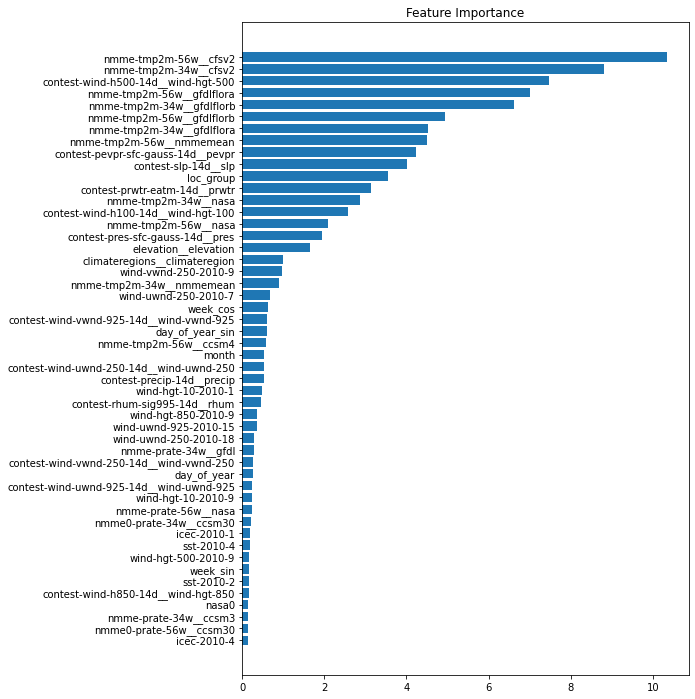

In [11]:
import matplotlib.pyplot as plt
feature_importance = bst.feature_importances_
max_features = 50
sorted_idx = np.argsort(feature_importance)[-max_features:]
fig = plt.figure(figsize=(8, 12))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_val.columns)[sorted_idx])
plt.title('Feature Importance')

<a id = "xml"></a>
# Explainability
In this section, we provide a sample for SHAP explainability evaluation of the model.

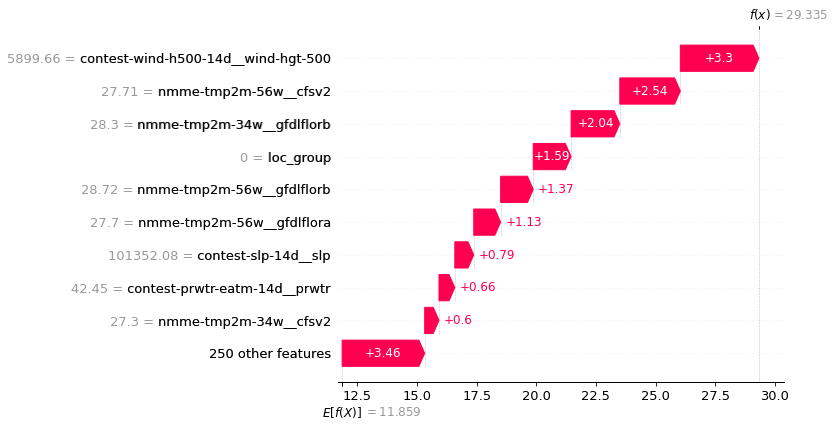

In [12]:
import shap

explainer = shap.Explainer(bst)
shap_values = explainer(X1)

# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])

In [13]:
# visualize the first prediction's explanation with a force plot
shap.plots.force(shap_values[0])

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


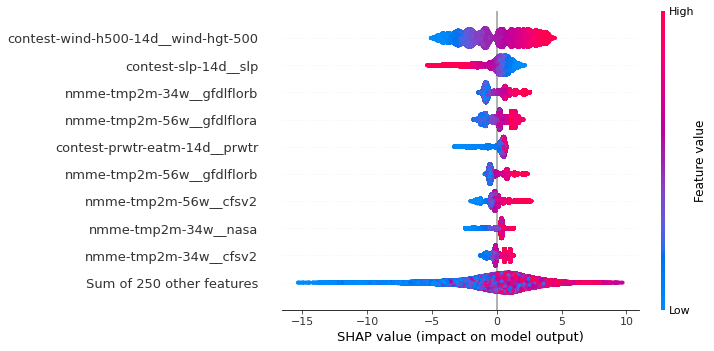

In [14]:
# summarize the effects of all the features
shap.plots.beeswarm(shap_values)

<a id = "PL"></a>
# Pseudo Labeling and Postprocessing

In [42]:
y_pred_prob =  bst.predict(X_test, prediction_type='Probability')
y_pred_prob

array([[7.37632178e-13, 1.00000000e+00],
       [7.01660952e-13, 1.00000000e+00],
       [6.26831920e-13, 1.00000000e+00],
       ...,
       [1.19347921e-02, 9.88065208e-01],
       [2.44049596e-02, 9.75595040e-01],
       [1.71288235e-02, 9.82871177e-01]])

(array([3.1303e+04, 2.3000e+01, 1.2000e+01, 2.0000e+00, 5.0000e+00,
        3.0000e+00, 2.0000e+00, 2.0000e+00, 0.0000e+00, 2.0000e+00]),
 array([5.10702591e-14, 7.36708397e-02, 1.47341679e-01, 2.21012519e-01,
        2.94683359e-01, 3.68354199e-01, 4.42025038e-01, 5.15695878e-01,
        5.89366718e-01, 6.63037558e-01, 7.36708397e-01]),
 <BarContainer object of 10 artists>)

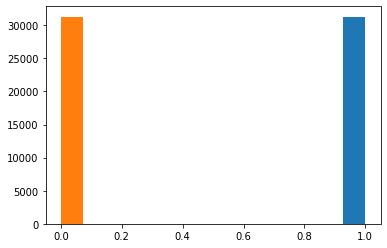

In [43]:
plt.hist(y_pred_prob[:,1], bins = 10)
plt.hist(y_pred_prob[:,0], bins = 10)

In [44]:
y_test_pred  = bst.predict(X_test)
y_test_pred

array([27.93518764, 27.98537427, 28.09823149, ...,  4.41629086,
        3.68826121,  4.04971543])

In [45]:
class RmseObjective(object):
    def calc_ders_range(self, approxes, targets, weights):
        assert len(approxes) == len(targets)
        targets[np.isnan(targets)] = 0
        approxes[np.isnan(approxes)] = 0
        if weights is not None:
            assert len(weights) == len(approxes)

        result = []
        for index in range(len(targets)):

            der1 = targets[index] - approxes[index]
            der2 = -1

            if weights is not None:
                der1 *= weights[index]
                der2 *= weights[index]

            result.append((der1, der2))
        return result

In [46]:
from sklego.model_selection import GroupTimeSeriesSplit

# Pseudo Labelling
train_pseudo = X_test.copy()
y_test_pred  = bst.predict(X_test)
train_pseudo[target] = y_test_pred
X_train_new = X1.copy()
X_train_new[target] = Y1

train_pseudo = train_pseudo.astype(float)
X_train_new = X_train_new.astype(float)

train_mod = pd.concat([X_train_new, train_pseudo], axis=0).reset_index(drop=True)
features = [c for c in X_test.columns if (c != 'id')]
display(train_mod)

XX = train_mod[features]
yy = train_mod[target]
y_oof_pred = np.zeros(len(yy))

X_testt = X_test[features].values
y_test_pred2 = np.zeros(len(X_testt))

error = 0

num_folds = 5

SEED = 114
use_cuda = 0

cv = GroupTimeSeriesSplit(3)
cvs = cv.split(XX, yy, XX['year'])

# GroupTimeSeriesSplit().split(X, groups=train_mod['year'].sort_values())
for i, (train_index, val_index) in enumerate(cv.split(XX, yy, XX['year'])):
    print(f"Fold {i+1}: Train Set: {train_mod.loc[train_index, 'year'].unique()}, Validation Set: {train_mod.loc[val_index, 'year'].unique()}")

    X_train4 = XX.loc[train_index].values
    X_val4 = XX.loc[val_index].values
    y_train4 = yy[train_index].values
    y_val4 = yy[val_index].values
    print(np.isnan(y_val4))
    train_pool = Pool(data=X_train4,label = y_train4)

    y_val4[np.isnan(y_val4)] = 0
    print(yy)
    
    model = CatBoostRegressor(**opt_params)

    model.fit(train_pool, eval_set=(X_val4, y_val4), plot=True, silent=True)

    if use_cuda: # check if GPU is enabled
        print(f"\nModel: Catboost")

        catb = CatBoostRegressor(
                verbose = 500,
                early_stopping_rounds = 250,
                random_seed = SEED,
                max_depth = 12,
                task_type = 'GPU',
                learning_rate = 0.05,
                iterations = 2000
            )

        catb.fit(X_train4, 
                 y_train4, 
                 eval_set = (X_val4, y_val4)) 

    if use_cuda: # check if GPU is enabled
        y_val_pred = LGB_WEIGHT * model.predict(X_val4) + CATB_WEIGHT * catb.predict(X_val4)
        y_test_pred2 += LGB_WEIGHT * model.predict(X_testt) + CATB_WEIGHT * catb.predict(X_testt)

    else:
        y_val_pred = model.predict(X_val4)
        y_test_pred2 += model.predict(X_testt)
    
    y_val4[np.isnan(y_val4)] = 0
    y_val_pred[np.isnan(y_val_pred)] = 0
    rmse_fold = np.sqrt(mean_squared_error(y_val_pred, y_val4))
    error += rmse_fold
    y_oof_pred[val_index] = y_val_pred


print(f"Mean RMSE: {error/num_folds}")
# print(f"Mean RMSE: {np.sqrt(mean_squared_error(y_oof_pred, y))}")


# Calculate evaluation metric for out of fold validation set
y_test_pred2 = y_test_pred2 / num_folds

submit[target] = (submit[target] + y_test_pred2)/2

,contest-pevpr-sfc-gauss-14d__pevpr,nmme0-tmp2m-34w__cancm30,nmme0-tmp2m-34w__cancm40,nmme0-tmp2m-34w__ccsm30,nmme0-tmp2m-34w__ccsm40,nmme0-tmp2m-34w__cfsv20,nmme0-tmp2m-34w__gfdlflora0,nmme0-tmp2m-34w__gfdlflorb0,nmme0-tmp2m-34w__gfdl0,nmme0-tmp2m-34w__nasa0,nmme0-tmp2m-34w__nmme0mean,contest-wind-h10-14d__wind-hgt-10,nmme-tmp2m-56w__cancm3,nmme-tmp2m-56w__cancm4,nmme-tmp2m-56w__ccsm3,nmme-tmp2m-56w__ccsm4,nmme-tmp2m-56w__cfsv2,nmme-tmp2m-56w__gfdl,nmme-tmp2m-56w__gfdlflora,nmme-tmp2m-56w__gfdlflorb,nmme-tmp2m-56w__nasa,nmme-tmp2m-56w__nmmemean,contest-rhum-sig995-14d__rhum,nmme-prate-34w__cancm3,nmme-prate-34w__cancm4,nmme-prate-34w__ccsm3,nmme-prate-34w__ccsm4,nmme-prate-34w__cfsv2,nmme-prate-34w__gfdl,nmme-prate-34w__gfdlflora,nmme-prate-34w__gfdlflorb,nmme-prate-34w__nasa,nmme-prate-34w__nmmemean,contest-wind-h100-14d__wind-hgt-100,nmme0-prate-56w__cancm30,nmme0-prate-56w__cancm40,nmme0-prate-56w__ccsm30,nmme0-prate-56w__ccsm40,nmme0-prate-56w__cfsv20,nmme0-prate-56w__gfdlflora0,nmme0-prate-56w__gfdlflorb0,nmme0-prate-56w__gfdl0,nmme0-prate-56w__nasa0,nmme0-prate-56w__nmme0mean,nmme0-prate-34w__cancm30,nmme0-prate-34w__cancm40,nmme0-prate-34w__ccsm30,nmme0-prate-34w__ccsm40,nmme0-prate-34w__cfsv20,nmme0-prate-34w__gfdlflora0,nmme0-prate-34w__gfdlflorb0,nmme0-prate-34w__gfdl0,nmme0-prate-34w__nasa0,nmme0-prate-34w__nmme0mean,contest-slp-14d__slp,contest-wind-vwnd-925-14d__wind-vwnd-925,nmme-prate-56w__cancm3,nmme-prate-56w__cancm4,nmme-prate-56w__ccsm3,nmme-prate-56w__ccsm4,nmme-prate-56w__cfsv2,nmme-prate-56w__gfdl,nmme-prate-56w__gfdlflora,nmme-prate-56w__gfdlflorb,nmme-prate-56w__nasa,nmme-prate-56w__nmmemean,contest-pres-sfc-gauss-14d__pres,contest-wind-uwnd-250-14d__wind-uwnd-250,nmme-tmp2m-34w__cancm3,nmme-tmp2m-34w__cancm4,nmme-tmp2m-34w__ccsm3,nmme-tmp2m-34w__ccsm4,nmme-tmp2m-34w__cfsv2,nmme-tmp2m-34w__gfdl,nmme-tmp2m-34w__gfdlflora,nmme-tmp2m-34w__gfdlflorb,nmme-tmp2m-34w__nasa,nmme-tmp2m-34w__nmmemean,contest-prwtr-eatm-14d__prwtr,contest-wind-vwnd-250-14d__wind-vwnd-250,contest-precip-14d__precip,contest-wind-h850-14d__wind-hgt-850,contest-wind-uwnd-925-14d__wind-uwnd-925,contest-wind-h500-14d__wind-hgt-500,cancm30,cancm40,ccsm30,ccsm40,cfsv20,gfdlflora0,gfdlflorb0,gfdl0,nasa0,nmme0mean,climateregions__climateregion,elevation__elevation,wind-vwnd-250-2010-1,wind-vwnd-250-2010-2,wind-vwnd-250-2010-3,wind-vwnd-250-2010-4,wind-vwnd-250-2010-5,wind-vwnd-250-2010-6,wind-vwnd-250-2010-7,wind-vwnd-250-2010-8,wind-vwnd-250-2010-9,wind-vwnd-250-2010-10,wind-vwnd-250-2010-11,wind-vwnd-250-2010-12,wind-vwnd-250-2010-13,wind-vwnd-250-2010-14,wind-vwnd-250-2010-15,wind-vwnd-250-2010-16,wind-vwnd-250-2010-17,wind-vwnd-250-2010-18,wind-vwnd-250-2010-19,wind-vwnd-250-2010-20,wind-uwnd-250-2010-1,wind-uwnd-250-2010-2,wind-uwnd-250-2010-3,wind-uwnd-250-2010-4,wind-uwnd-250-2010-5,wind-uwnd-250-2010-6,wind-uwnd-250-2010-7,wind-uwnd-250-2010-8,wind-uwnd-250-2010-9,wind-uwnd-250-2010-10,wind-uwnd-250-2010-11,wind-uwnd-250-2010-12,wind-uwnd-250-2010-13,wind-uwnd-250-2010-14,wind-uwnd-250-2010-15,wind-uwnd-250-2010-16,wind-uwnd-250-2010-17,wind-uwnd-250-2010-18,wind-uwnd-250-2010-19,wind-uwnd-250-2010-20,mjo1d__phase,mjo1d__amplitude,mei__mei,mei__meirank,mei__nip,wind-hgt-850-2010-1,wind-hgt-850-2010-2,wind-hgt-850-2010-3,wind-hgt-850-2010-4,wind-hgt-850-2010-5,wind-hgt-850-2010-6,wind-hgt-850-2010-7,wind-hgt-850-2010-8,wind-hgt-850-2010-9,wind-hgt-850-2010-10,sst-2010-1,sst-2010-2,sst-2010-3,sst-2010-4,sst-2010-5,sst-2010-6,sst-2010-7,sst-2010-8,sst-2010-9,sst-2010-10,wind-hgt-500-2010-1,wind-hgt-500-2010-2,wind-hgt-500-2010-3,wind-hgt-500-2010-4,wind-hgt-500-2010-5,wind-hgt-500-2010-6,wind-hgt-500-2010-7,wind-hgt-500-2010-8,wind-hgt-500-2010-9,wind-hgt-500-2010-10,icec-2010-1,icec-2010-2,icec-2010-3,icec-2010-4,icec-2010-5,icec-2010-6,icec-2010-7,icec-2010-8,icec-2010-9,icec-2010-10,wind-uwnd-925-2010-1,wind-uwnd-925-2010-2,wind-uwnd-925-2010-3,wind-uwnd-925-2010-4,wind-uwnd-925-2010-5,wind-uwnd-925-2010-6,wind-uwnd-925-2010-7,wind

Fold 1: Train Set: [2014.], Validation Set: [2015.]
[False False False ... False False False]
0         28.744480
1         28.370585
2         28.133059
3         28.256798
4         28.372353
            ...    
407083     5.182409
407084     4.879146
407085     4.416291
407086     3.688261
407087     4.049715
Name: contest-tmp2m-14d__tmp2m, Length: 407088, dtype: float64


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Fold 2: Train Set: [2015.], Validation Set: [2016.]
[False False False ... False False False]
0         28.744480
1         28.370585
2         28.133059
3         28.256798
4         28.372353
            ...    
407083     5.182409
407084     4.879146
407085     4.416291
407086     3.688261
407087     4.049715
Name: contest-tmp2m-14d__tmp2m, Length: 407088, dtype: float64


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Fold 3: Train Set: [2016.], Validation Set: [2022.]
[False False False ... False False False]
0         28.744480
1         28.370585
2         28.133059
3         28.256798
4         28.372353
            ...    
407083     5.182409
407084     4.879146
407085     4.416291
407086     3.688261
407087     4.049715
Name: contest-tmp2m-14d__tmp2m, Length: 407088, dtype: float64


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Mean RMSE: 1.3324691414530754


In [47]:
## Pseudo Labeling without CV
yy[np.isnan(yy)] = 0
train_pool = Pool(data=XX,label = yy)

X_train3, X_test3, y_trai3, y_test3 = train_test_split(XX, yy, test_size=0.33, random_state=42)

bst2 = CatBoostRegressor(**opt_params)
bst2.fit(train_pool, eval_set=(X_test3, y_test3), plot=True,silent=True)
print(bst2.get_best_score())

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

{'learn': {'RMSE': 0.3476080530620145}, 'validation': {'RMSE': 0.34649347722980794}}


<a id="submit"></a>
# Submission

In [48]:
submit[target] = bst2.predict(X_test)
submit.to_csv('submission19.csv', index = False)

## Todo!
Ensemble, Ensemble, Ensemble